In [157]:
import numpy as np
import pylab as pl
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib 
import seaborn as sns
%matplotlib inline

from sklearn.utils import shuffle
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,classification_report, roc_auc_score, f1_score, recall_score, precision_score, accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV

In [158]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [159]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17158 entries, 0 to 17157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      17158 non-null  int64  
 1   city                    17158 non-null  object 
 2   city_development_index  17158 non-null  float64
 3   gender                  13120 non-null  object 
 4   relevent_experience     17158 non-null  object 
 5   enrolled_university     16807 non-null  object 
 6   education_level         16744 non-null  object 
 7   major_discipline        14630 non-null  object 
 8   experience              17105 non-null  object 
 9   company_size            11831 non-null  object 
 10  company_type            11645 non-null  object 
 11  last_new_job            16774 non-null  object 
 12  training_hours          17158 non-null  int64  
 13  target                  17158 non-null  int64  
dtypes: float64(1), int64(3), object(10)
me

In [160]:
pd.qcut(train['city_development_index'], 3)

0         (0.804, 0.92]
1        (0.447, 0.804]
2         (0.92, 0.949]
3         (0.92, 0.949]
4         (0.804, 0.92]
              ...      
17153    (0.447, 0.804]
17154    (0.447, 0.804]
17155    (0.447, 0.804]
17156     (0.804, 0.92]
17157     (0.804, 0.92]
Name: city_development_index, Length: 17158, dtype: category
Categories (3, interval[float64, right]): [(0.447, 0.804] < (0.804, 0.92] < (0.92, 0.949]]

In [161]:
train["city_type"] = np.where(train["city_development_index"]<=0.804, "small city", "mid city")
train["city_type"] = np.where((0.804 < train["city_development_index"]) & (train["city_development_index"] <= 0.92), "mid city", train["city_type"])
train["city_type"] = np.where((0.92 < train["city_development_index"]) & (train["city_development_index"] <= 0.950), "big city", train["city_type"])

In [162]:
test["city_type"] = np.where(test["city_development_index"]<=0.804, "small city", "mid city")
test["city_type"] = np.where((0.804 < test["city_development_index"]) & (test["city_development_index"] <= 0.92), "mid city", test["city_type"])
test["city_type"] = np.where((0.92 < test["city_development_index"]) & (test["city_development_index"] <= 0.950), "big city", test["city_type"])

In [163]:
# 이상치 제거 코드

# def outliers_iqr(data):
#     q1, q3 = np.percentile(data, [25, 75])
#     iqr = q3 - q1

#     lower_bound = q1 - (iqr*1.5)
#     upper_bound = q3 + (iqr*1.5)

#     return np.where((data > upper_bound) | (data < lower_bound))

# df_out_city_di = outliers_iqr(train['city_development_index'])[0]
# df_out_training = outliers_iqr(train['training_hours'])[0]

# out_index = np.concatenate((
#     df_out_city_di,
#     df_out_training
#     ))

# print(len(out_index))

# not_out = []

# for i in train.index:
#     if i not in out_index:
#         not_out.append(i)

# train = train.loc[not_out]
# train = train.reset_index(drop=True)

In [164]:
train.head()

,id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target,city_type
0,4064,city_160,0.920,NaN,Has relevent experience,no_enrollment,Graduate,STEM,18,NaN,NaN,1,198,1,mid city
1,33238,city_90,0.698,Male,Has relevent experience,no_enrollment,Graduate,STEM,7,NaN,NaN,1,149,0,small city
2,20922,city_114,0.926,NaN,No relevent experience,no_enrollment,High School,NaN,3,NaN,NaN,never,9,0,big city
3,2290,city_114,0.926,Male,Has relevent experience,no_enrollment,Masters,STEM,15,10000+,Pvt Ltd,2,5,0,big city
4,3246,city_100,0.887,Male,Has relevent experience,Full time course,NaN,NaN,14,NaN,NaN,1,43,1,mid city


In [165]:
train.drop('city', axis=1, inplace=True)
test.drop('city', axis=1, inplace=True)

train.drop('id', axis=1, inplace=True)
test.drop('id', axis=1, inplace=True)

In [166]:
def rel_experience(x):
    if x=='Has relevent experience': return 1
    if x=='No relevent experience':   return 0
    
def enrollment(x):
    if x=='no_enrollment'   : return 0
    if x=='Full time course':   return 1 
    if x=='Part time course':   return 2 
    
def edu_level(x):
    if x=='Graduate'       :   return 0
    if x=='Masters'        :   return 1 
    if x=='High School'    :   return 2 
    if x=='Phd'            :   return 3 
    if x=='Primary School' :   return 4 
    
def major(df):
    df["major_discipline"] = np.where(df["education_level"]=="High School", "High School", df["major_discipline"])
    df["major_discipline"] = np.where(df["education_level"]=="Primary School", "Primary School", df["major_discipline"])
    
    return df["major_discipline"]
    
def experience(x):
    if x=='<1'      :   return 0
    if x=='1'       :   return 1 
    if x=='2'       :   return 2 
    if x=='3'       :   return 3 
    if x=='4'       :   return 4 
    if x=='5'       :   return 5
    if x=='6'       :   return 6
    if x=='7'       :   return 7
    if x=='8'       :   return 8 
    if x=='9'       :   return 9 
    if x=='10'      :   return 10 
    if x=='11'      :   return 11
    if x=='12'      :   return 12
    if x=='13'      :   return 13 
    if x=='14'      :   return 14 
    if x=='15'      :   return 15 
    if x=='16'      :   return 16
    if x=='17'      :   return 17
    if x=='18'      :   return 18
    if x=='19'      :   return 19 
    if x=='20'      :   return 20 
    if x=='>20'     :   return 21 
    
def company_t(x):
    if x=='Pvt Ltd'               :   return 0
    if x=='Funded Startup'        :   return 1 
    if x=='Early Stage Startup'   :   return 2 
    if x=='Other'                 :   return 3 
    if x=='Public Sector'         :   return 4 
    if x=='NGO'                   :   return 5 
    
def company_s(x):
    if x=='<10'          :   return 0
    if x=='10/49'        :   return 1 
    if x=='100-500'      :   return 2 
    if x=='1000-4999'    :   return 3 
    if x=='10000+'       :   return 4 
    if x=='50-99'        :   return 5 
    if x=='500-999'      :   return 6 
    if x=='5000-9999'    :   return 7
    
def last_job(x):
    if x=='never'        :   return 0
    if x=='1'            :   return 1 
    if x=='2'            :   return 2 
    if x=='3'            :   return 3 
    if x=='4'            :   return 4 
    if x=='>4'           :   return 5 
    
def city_type(x):
    if x == "small city": return 0
    if x == "mid city": return 1
    if x == "big city": return 2

In [167]:
train_major = pd.get_dummies(train['major_discipline'])
train_gender = pd.get_dummies(train['gender'])

In [168]:
train_major['Other_sub'] = train_major['Other']
train_major.drop('Other', axis=1, inplace=True)

In [169]:
train_major.head()

,Arts,Business Degree,Humanities,No Major,STEM,Other_sub
0,0,0,0,0,1,0
1,0,0,0,0,1,0
2,0,0,0,0,0,0
3,0,0,0,0,1,0
4,0,0,0,0,0,0


In [170]:
train['relevent_experience'] = train['relevent_experience'].apply(rel_experience)
train['enrolled_university'] = train['enrolled_university'].apply(enrollment)
train['education_level'] = train['education_level'].apply(edu_level)
train['experience'] = train['experience'].apply(experience)
train['company_type'] = train['company_type'].apply(company_t)
train['company_size'] = train['company_size'].apply(company_s)
train['last_new_job'] = train['last_new_job'].apply(last_job)
train['city_type'] = train['city_type'].apply(city_type)
train.drop(['major_discipline', 'gender'], axis=1, inplace=True)

train = pd.concat([train, train_major, train_gender], axis=1)

In [171]:
train['enrolled_university'] = train['enrolled_university'].fillna((train['enrolled_university'].mean()))
train['company_size'] = train['company_size'].fillna((train['company_size'].mean()))
train['company_type'] = train['company_type'].fillna((train['company_type'].mean()))
train['education_level'] = train['education_level'].fillna((train['education_level'].mean()))
train['last_new_job'] = train['last_new_job'].fillna((train['last_new_job'].mean()))
train['experience'] = train['experience'].fillna((train['experience'].mean()))

In [172]:
train.isnull().sum()

city_development_index    0
relevent_experience       0
enrolled_university       0
education_level           0
experience                0
company_size              0
company_type              0
last_new_job              0
training_hours            0
target                    0
city_type                 0
Arts                      0
Business Degree           0
Humanities                0
No Major                  0
STEM                      0
Other_sub                 0
Female                    0
Male                      0
Other                     0
dtype: int64

In [173]:
test_major = pd.get_dummies(test['major_discipline'])
test_gender = pd.get_dummies(test['gender'])

In [174]:
test_major['Other_sub'] = test_major['Other']
test_major.drop('Other', axis=1, inplace=True)

In [175]:
test['relevent_experience'] = test['relevent_experience'].apply(rel_experience)
test['enrolled_university'] = test['enrolled_university'].apply(enrollment)
test['education_level'] = test['education_level'].apply(edu_level)
test['experience'] = test['experience'].apply(experience)
test['company_type'] = test['company_type'].apply(company_t)
test['company_size'] = test['company_size'].apply(company_s)
test['last_new_job'] = test['last_new_job'].apply(last_job)
test['city_type'] = test['city_type'].apply(city_type)
test.drop(['major_discipline', 'gender'], axis=1, inplace=True)

test = pd.concat([test, test_major, test_gender], axis=1)

In [176]:
test['enrolled_university'] = test['enrolled_university'].fillna((test['enrolled_university'].mean()))
test['company_size'] = test['company_size'].fillna((test['company_size'].mean()))
test['company_type'] = test['company_type'].fillna((test['company_type'].mean()))
test['company_type'] = test['company_type'].fillna((test['company_type'].mean()))
test['education_level'] = test['education_level'].fillna((test['education_level'].mean()))
test['last_new_job'] = test['last_new_job'].fillna((test['last_new_job'].mean()))
test['experience'] = test['experience'].fillna((test['experience'].mean()))

In [177]:
from sklearn.model_selection import train_test_split
y = train['target']
X = train.drop(columns=['target'])

Xt = test.drop('target', axis=1)
yt = test['target']

In [42]:
pip install catboost

     |████████████████████████████████| 76.1 MB 53 kB/s 


In [178]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier

def modeling(model, X_train, y_train, X_test, y_test, name):
    model = model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    res = pd.DataFrame(
        data=[accuracy_score(y_test, y_pred), recall_score(y_test, y_pred),
        precision_score(y_test, y_pred), roc_auc_score(y_test, y_pred), f1_score(y_test, y_pred)],
        columns=[name], index=["Accuracy", "Recall", "Precision", "ROC AUC Score", "F1 Score"]
        )
    
    return res

In [179]:
model_random = RandomForestClassifier(
    n_estimators = 12, 
    max_depth = 12,
    min_samples_leaf = 8,
    min_samples_split = 4,
    random_state = 0,
    n_jobs = -1
    )

model_log = LogisticRegression(
    C = 0.01, 
    penalty = 'l2'
    )

model_light = LGBMClassifier(
    learning_rate = 0.05, 
    max_depth = -1, 
    min_child_samples = 15, 
    num_leaves = 20, 
    reg_alpha = 0.01
    )


model_KN = KNeighborsClassifier(
    metric = 'manhattan', 
    n_neighbors = 16, 
    weights = 'uniform'
    )

model_SVC = SVC(
    C = 1000, 
    gamma = 0.001, 
    kernel = 'rbf'
    )

model_cat = CatBoostClassifier(
    depth = 5,
    iterations =  500,
    l2_leaf_reg = 1e-20,
    leaf_estimation_iterations = 10,
    logging_level = 'Silent',
    loss_function = 'Logloss',
    random_seed = 42
    )   

In [180]:
random_res = modeling(model_random, X, y, Xt, yt, "RandomForest Score")
logistic_res = modeling(model_log, X, y, Xt, yt, "Logistic Score")
lightGBM_res = modeling(model_light, X, y, Xt, yt, "LightGBM Score")
KNN_res = modeling(model_KN, X, y, Xt, yt, "KNN Score")
SVC_res = modeling(model_SVC, X, y, Xt, yt, "SVC Score")
cat_res = modeling(model_cat, X, y, Xt, yt, "Catboost Score")

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [181]:
res_df = round(pd.concat([random_res, logistic_res, lightGBM_res, KNN_res, SVC_res, cat_res], axis=1), 3).T
res_df

,Accuracy,Recall,Precision,ROC AUC Score,F1 Score
RandomForest Score,0.790,0.519,0.611,0.702,0.562
Logistic Score,0.748,0.131,0.553,0.547,0.212
LightGBM Score,0.798,0.649,0.603,0.750,0.625
KNN Score,0.758,0.207,0.591,0.578,0.306
SVC Score,0.755,0.243,0.562,0.589,0.340
Catboost Score,0.792,0.542,0.610,0.711,0.574


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.


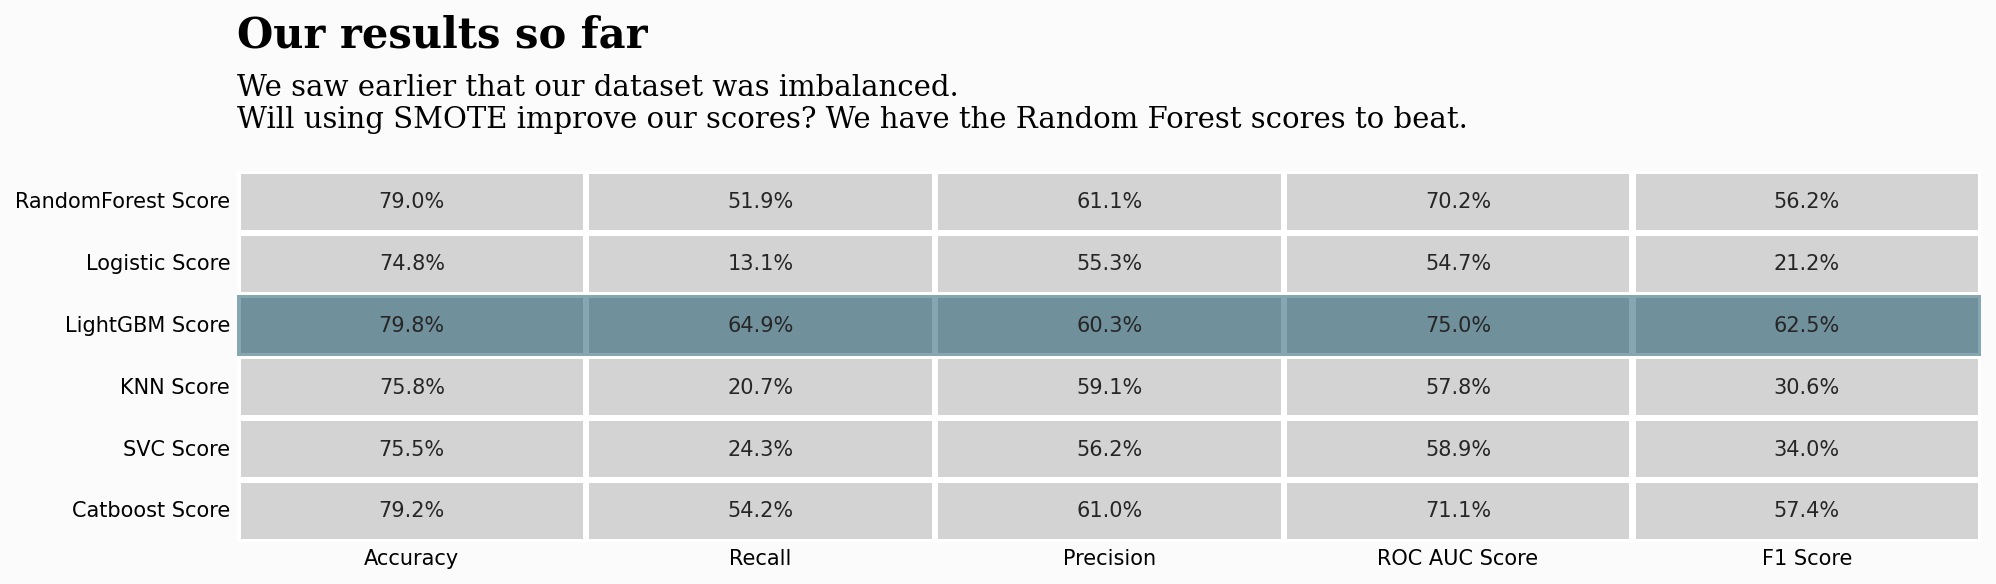

In [184]:
fig = plt.figure(figsize=(15,18), dpi=150)
gs = fig.add_gridspec(4, 2)
gs.update(wspace=0.1, hspace=0.5)
ax0 = fig.add_subplot(gs[0, :])

colors = ["lightgray","lightgray"]
colormap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)
# Change background color
background_color = "#fbfbfb"
fig.patch.set_facecolor(background_color) # figure background color
ax0.set_facecolor(background_color)

# Overall
sns.heatmap(res_df, cmap=colormap,annot=True,fmt=".1%", linewidths=2.5,cbar=False,ax=ax0)

ax0.tick_params(axis=u'both', which=u'both',length=0)
ax0.text(0,-2,'Our results so far',fontfamily='serif',fontsize=20,fontweight='bold')
ax0.text(0,-0.7,'We saw earlier that our dataset was imbalanced.\nWill using SMOTE improve our scores? We have the Random Forest scores to beat.',fontfamily='serif',fontsize=14)

from matplotlib.patches import Rectangle

rect = ax0.add_patch(Rectangle((0, 2), 5, 1, fill=True,color='#0e4f66', edgecolor='white', lw=0,alpha=0.5))

In [185]:
# Our data is unbalanced, we can fix this with SMOTE

from imblearn.over_sampling import SMOTE

oversample = SMOTE()
X_resample, y_resample = oversample.fit_resample(X, y.ravel())

In [186]:
# from sklearn.metrics import f1_score, make_scorer

# f1 = make_scorer(f1_score , average='macro')

# params = {
#     'n_estimators' : [8, 10, 12],
#     'max_depth' : [12, 15, 18, 21],
#     'min_samples_leaf' : [4, 6, 8],
#     'min_samples_split' : [4, 6, 8]
#     }

# random_clf = RandomForestClassifier(random_state = 0, n_jobs = -1)
# grid_random = GridSearchCV(random_clf, params, cv = 5, n_jobs = -1, scoring=f1)
# grid_random.fit(X_resample, y_resample)
# print('최적 하이퍼 파라미터: ', grid_random.best_params_)

# params = {
#     "C":np.logspace(-3,3,7), 
#     "penalty":["l1","l2"]
#     }# l1 lasso l2 ridge
# log_clf = LogisticRegression()
# grid_log = GridSearchCV(log_clf, params, cv=5, scoring=f1)
# grid_log.fit(X_resample, y_resample)
# print('최적 하이퍼 파라미터: ', grid_log.best_params_)


# params = {
#     'num_leaves':[20,40,60,80,100], 
#     'min_child_samples':[5,10,15],
#     'max_depth':[-1,5,10,20], 
#     'learning_rate':[0.05,0.1,0.2],
#     'reg_alpha':[0,0.01,0.03]
#     }
# lgb_clf = LGBMClassifier()
# grid_lgb = GridSearchCV(lgb_clf, params, scoring=f1) 
# grid_lgb.fit(X_resample, y_resample) 
# print('최적 하이퍼 파라미터: ', grid_lgb.best_params_)

# params = {
#     'n_neighbors' : list(range(1,20)),
#     'weights' : ["uniform", "distance"],
#     'metric' : ['euclidean', 'manhattan', 'minkowski']
# }

# knn_clf = KNeighborsClassifier()
# grid_knn = GridSearchCV(knn_clf, params, cv=5, scoring=f1)
# grid_knn.fit(X_resample, y_resample)
# print('최적 하이퍼 파라미터: ', grid_knn.best_params_)

# cat_clf = CatBoostClassifier()
# params = {
#     'iterations': [500],
#     'depth': [4, 5, 6],
#     'loss_function': ['Logloss', 'CrossEntropy'],
#     'l2_leaf_reg': np.logspace(-20, -19, 3),
#     'leaf_estimation_iterations': [10],
# #   'eval_metric': ['Accuracy'],
# #   'use_best_model': ['True'],
#     'logging_level':['Silent'],
#     'random_seed': [42]
#     }
# grid_cat = GridSearchCV(cat_clf, params, scoring=f1, cv=5)
# grid_cat.fit(X_resample, y_resample)
# print('최적 하이퍼 파라미터: ', grid_cat.best_params_)

# param_grid = {'C': [0.1, 1, 10, 100, 1000],
#               'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
#               'kernel': ['rbf']}
 
# grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3, scoring=f1)
# grid.fit(X_resample, y_resample)
# print(grid.best_params_)

In [187]:
model_random_smote = RandomForestClassifier(
    n_estimators = 12, 
    max_depth = 21,
    min_samples_leaf = 6,
    min_samples_split = 4,
    random_state = 0,
    n_jobs = -1
    )

model_log_smote = LogisticRegression(
    C = 0.01, 
    penalty = 'l2'
    )

model_light_smote = LGBMClassifier(
    learning_rate = 0.05, 
    max_depth = 5, 
    min_child_samples = 10, 
    num_leaves = 40, 
    reg_alpha = 0
    )


model_KN_smote = KNeighborsClassifier(
    metric = 'manhattan', 
    n_neighbors = 2, 
    weights = 'distance'
    )

model_SVC_smote = SVC(
    C = 10, 
    gamma = 1, 
    kernel = 'rbf'
    )

model_cat_smote = CatBoostClassifier(
    depth = 6,
    iterations =  500,
    l2_leaf_reg = 1e-20,
    leaf_estimation_iterations = 10,
    logging_level = 'Silent',
    loss_function = 'Logloss',
    random_seed = 42
    )

In [188]:
random_res_smote = modeling(model_random_smote, X_resample, y_resample, Xt, yt, "RandomForest Score")
logistic_res_smote = modeling(model_log_smote, X_resample, y_resample, Xt, yt, "Logistic Score")
lightGBM_res_smote = modeling(model_light_smote, X_resample, y_resample, Xt, yt, "LightGBM Score")
KNN_res_smote = modeling(model_KN_smote, X_resample, y_resample, Xt, yt, "KNN Score")
SVC_res_smote = modeling(model_SVC_smote, X_resample, y_resample, Xt, yt, "SVC Score")
cat_res_smote = modeling(model_cat_smote, X_resample, y_resample, Xt, yt, "Catboost Score")

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [189]:
res_df_smote = round(pd.concat([random_res_smote, logistic_res_smote, lightGBM_res_smote, KNN_res_smote, SVC_res_smote, cat_res_smote], axis=1), 3).T
res_df_smote

,Accuracy,Recall,Precision,ROC AUC Score,F1 Score
RandomForest Score,0.767,0.653,0.542,0.730,0.592
Logistic Score,0.695,0.660,0.441,0.684,0.529
LightGBM Score,0.769,0.705,0.542,0.748,0.612
KNN Score,0.650,0.398,0.347,0.568,0.371
SVC Score,0.730,0.116,0.426,0.531,0.182
Catboost Score,0.776,0.695,0.555,0.750,0.617


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.


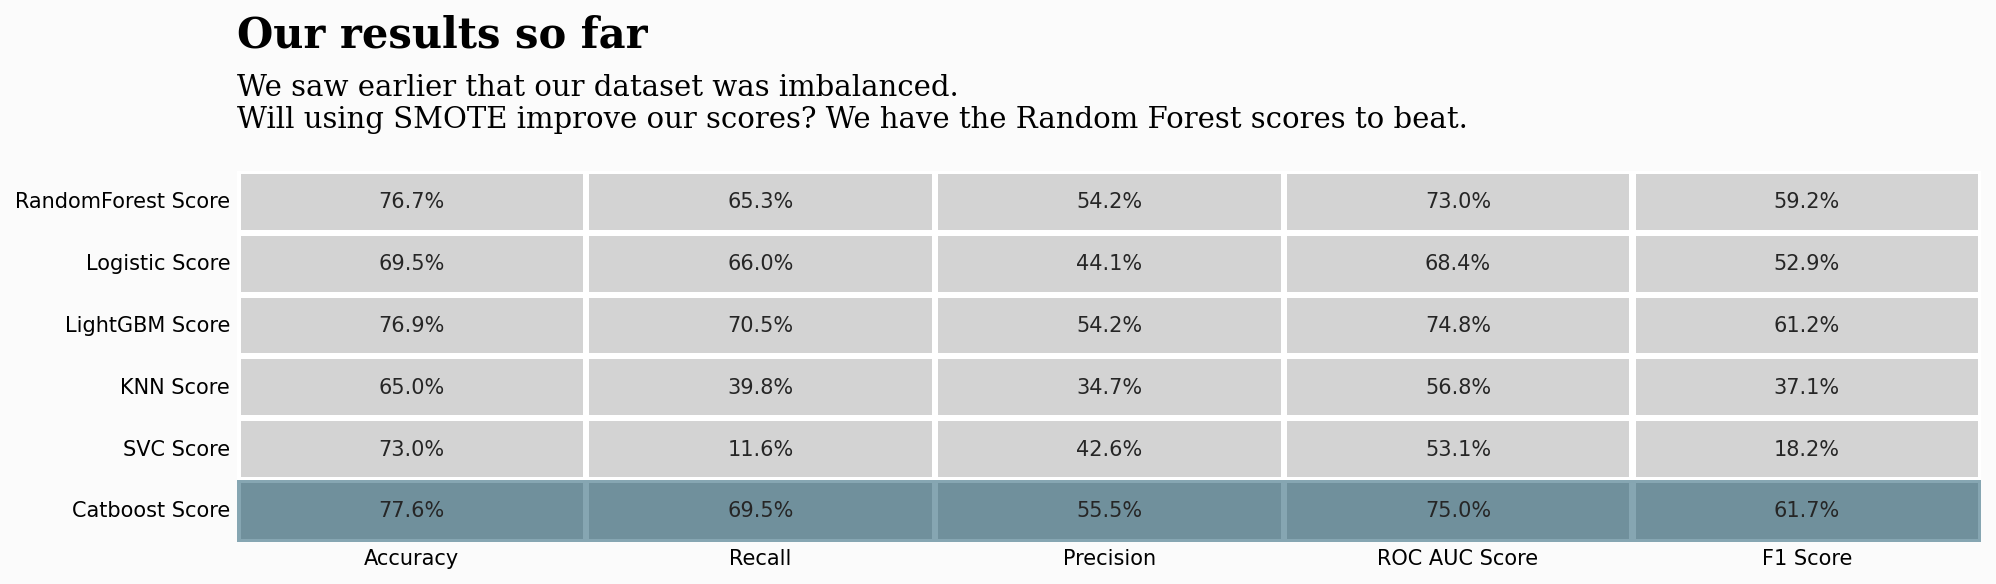

In [190]:
fig = plt.figure(figsize=(15,18), dpi=150)
gs = fig.add_gridspec(4, 2)
gs.update(wspace=0.1, hspace=0.5)
ax1 = fig.add_subplot(gs[0, :])

colors = ["lightgray","lightgray"]
colormap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)
# Change background color
background_color = "#fbfbfb"
fig.patch.set_facecolor(background_color) # figure background color
ax1.set_facecolor(background_color)

# Overall
sns.heatmap(res_df_smote, cmap=colormap,annot=True,fmt=".1%", linewidths=2.5,cbar=False,ax=ax1)

ax1.tick_params(axis=u'both', which=u'both',length=0)
ax1.text(0,-2,'Our results so far',fontfamily='serif',fontsize=20,fontweight='bold')
ax1.text(0,-0.7,'We saw earlier that our dataset was imbalanced.\nWill using SMOTE improve our scores? We have the Random Forest scores to beat.',fontfamily='serif',fontsize=14)

rect = ax1.add_patch(Rectangle((0, 5), 5, 1, fill=True,color='#0e4f66', edgecolor='white', lw=0,alpha=0.5))

In [192]:
X_res = pd.DataFrame(X_resample)
y_res = pd.DataFrame({'target' : y_resample})

train_smote = pd.concat([X_res, y_res], axis=1)
train_smote

,city_development_index,relevent_experience,enrolled_university,education_level,experience,company_size,company_type,last_new_job,training_hours,city_type,Arts,Business Degree,Humanities,No Major,STEM,Other_sub,Female,Male,Other,target
0,0.920000,1,0.000000,0.000000,18.000000,3.274787,0.688708,1.000000,198,1,0,0,0,0,1,0,0,0,0,1
1,0.698000,1,0.000000,0.000000,7.000000,3.274787,0.688708,1.000000,149,0,0,0,0,0,1,0,0,1,0,0
2,0.926000,0,0.000000,2.000000,3.000000,3.274787,0.688708,0.000000,9,2,0,0,0,0,0,0,0,0,0,0
3,0.926000,1,0.000000,1.000000,15.000000,4.000000,0.000000,2.000000,5,2,0,0,0,0,1,0,0,1,0,0
4,0.887000,1,1.000000,0.584388,14.000000,3.274787,0.688708,1.000000,43,1,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25793,0.922628,0,0.028369,1.877616,21.000000,3.274787,0.688708,1.086649,39,1,0,0,0,0,0,0,0,0,0,1
25794,0.624000,1,0.335718,1.000000,9.000000,2.335718,0.000000,4.832141,36,0,0,0,0,0,1,0,0,1,0,1
25795,0.606780,1,0.000000,0.767298,3.465403,5.000000,0.927562,1.000000,12,0,0,0,0,0,1,0,0,1,0,1
25796,0.624000,0,0.027155,0.000000,5.972845,2.034617,0.688708,1.000000,124,0,0,0,0,0,1,0,0,1,0,1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:93: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.


Text(0.125, 0, "\nThere is not much difference before using SMOTE. However, the recall score and ROC AUC score of the Catboost classification model\n    \nusing SMOTE show the best performance at 69.5% and 75%, respectively.\n    \n\nWith the highest recall score and ROC AUC score, this model can be used to predict who is looking for another job in HR.\n    \nIt will be possible to reduce the company's losses by predicting employees looking for other jobs in advance.\n    ")

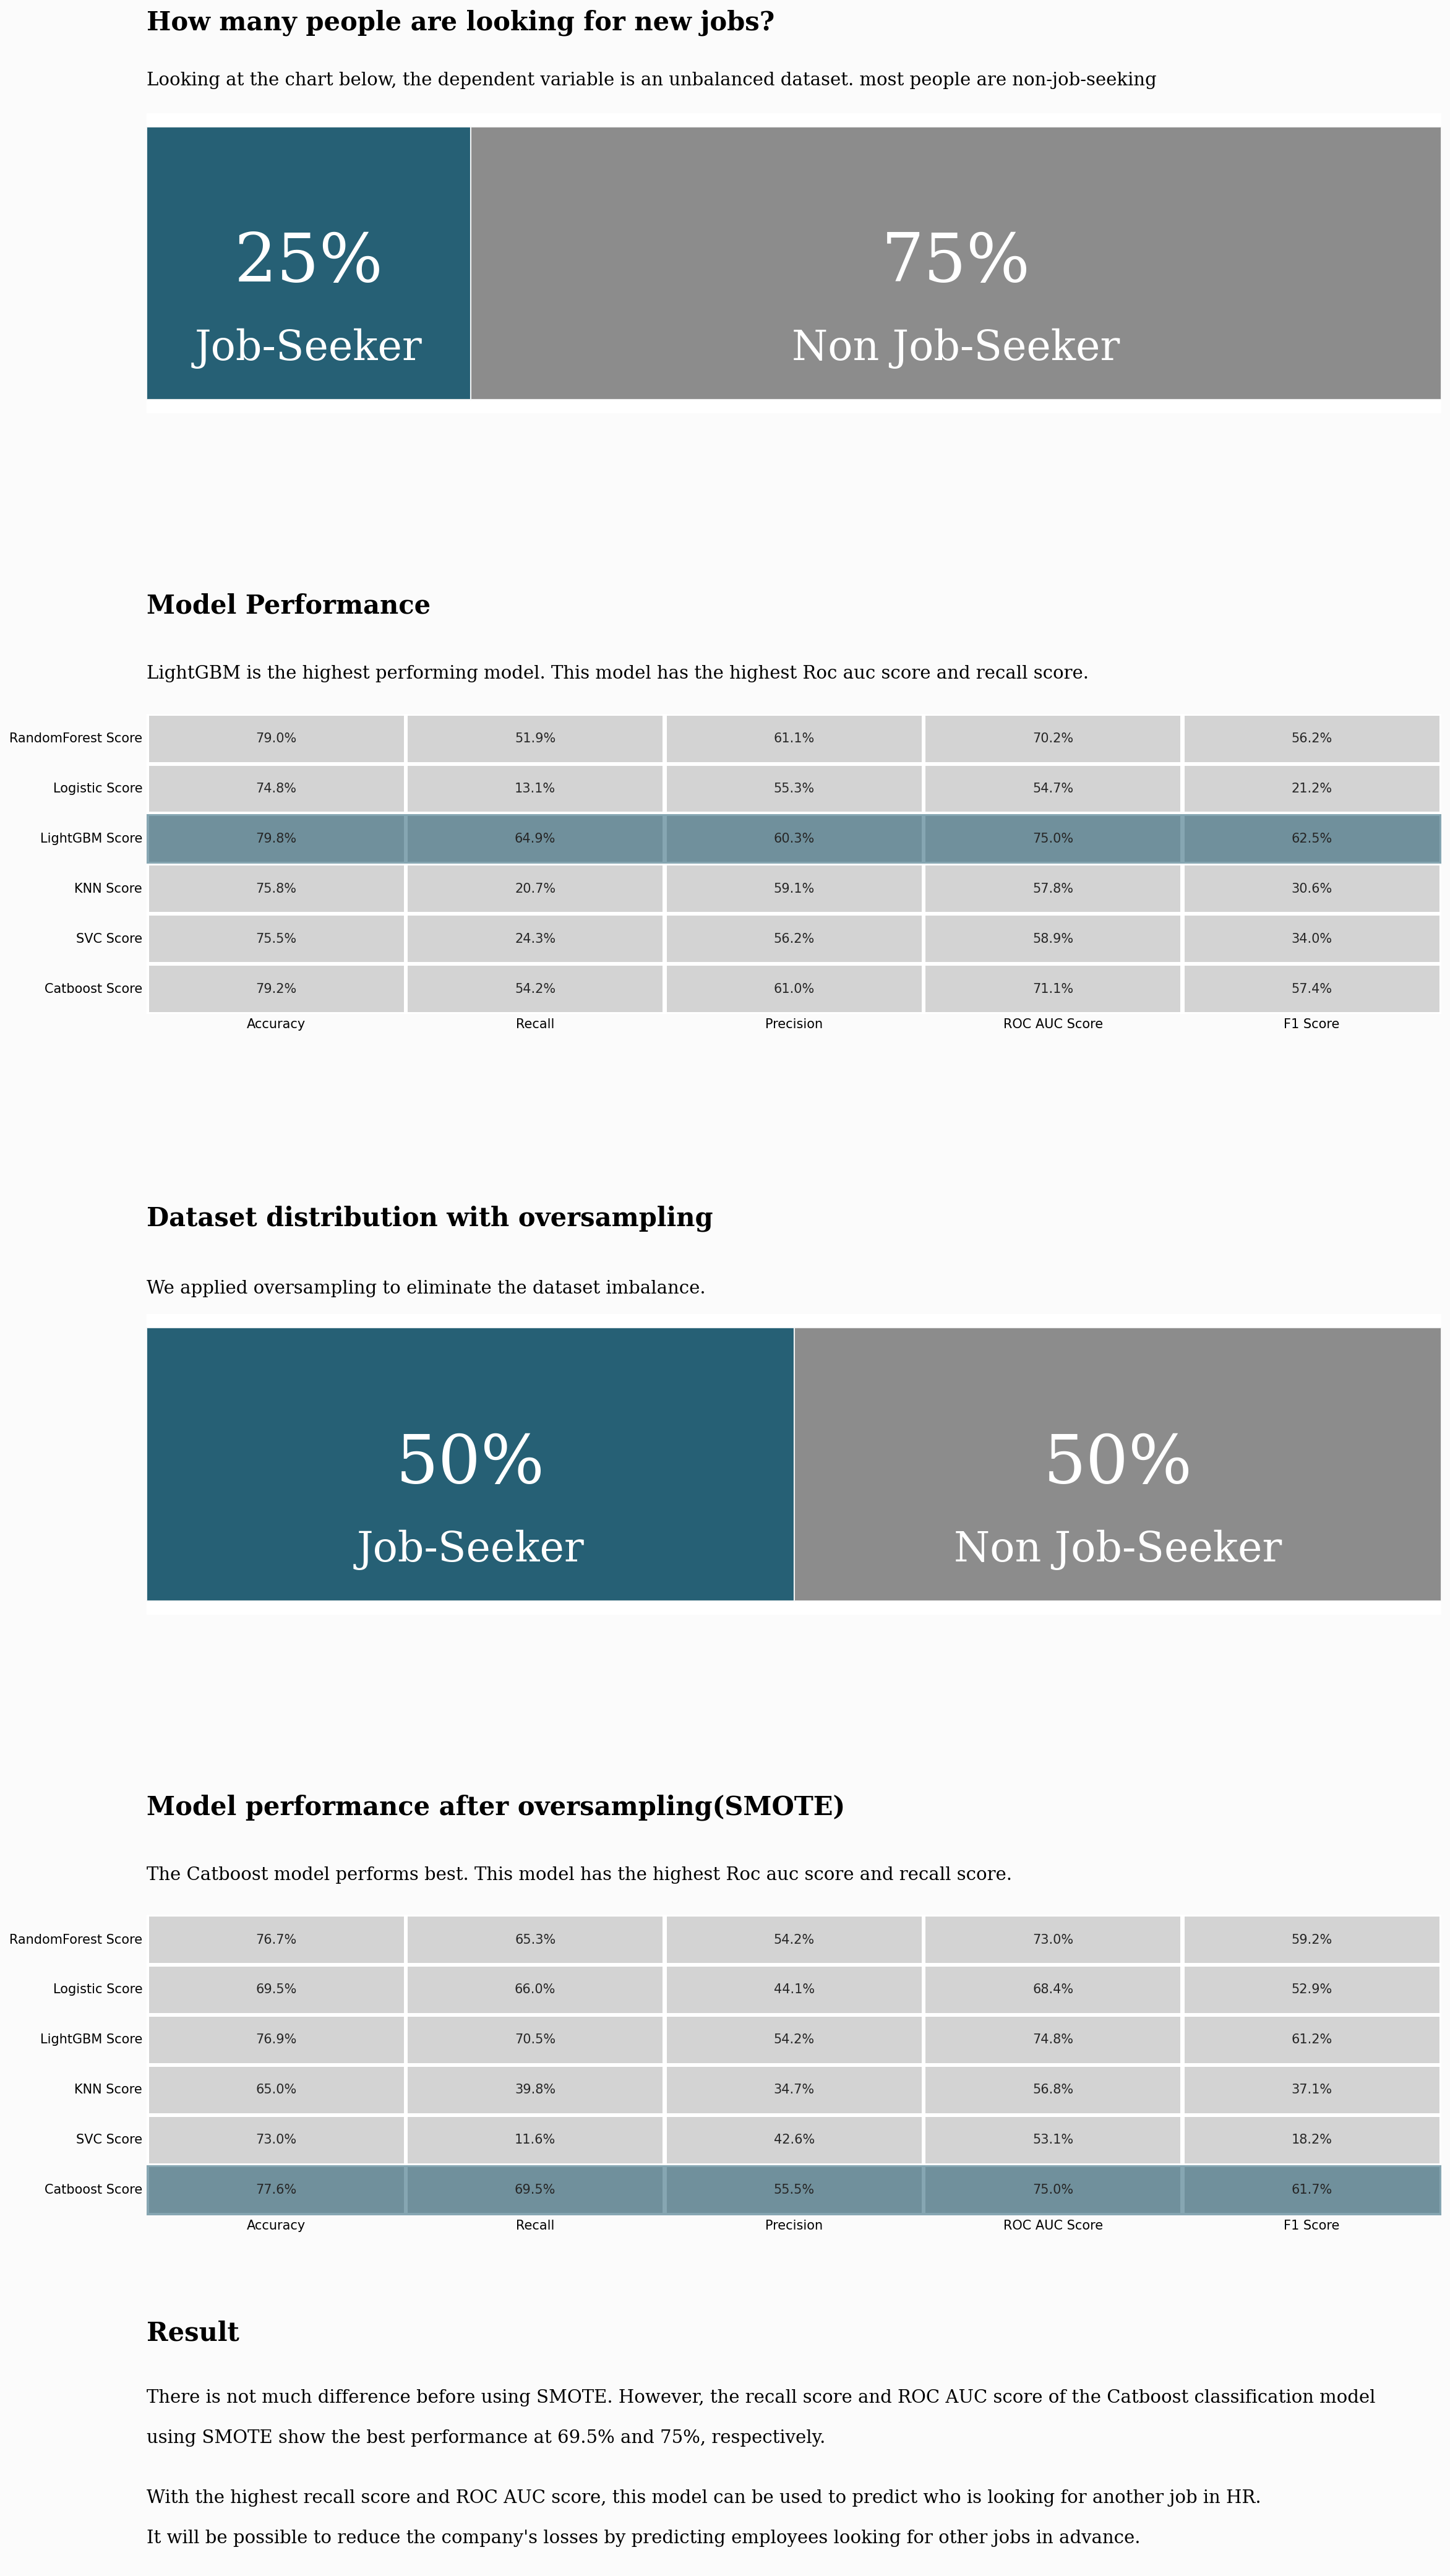

In [209]:
colors = ["lightgray","lightgray"]
colormap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)
# Change background color
background_color = "#fbfbfb"
fig.patch.set_facecolor(background_color) # figure background color

fig = plt.figure(figsize=(18, 30), dpi=150)
fig.patch.set_facecolor(background_color)
gs = fig.add_gridspec(4, 3)
gs.update(wspace=0.4, hspace=1)
ax0 = fig.add_subplot(gs[0, :])
ax1 = fig.add_subplot(gs[1, :])
ax2 = fig.add_subplot(gs[2, :])
ax3 = fig.add_subplot(gs[3, :])

x=train.groupby(['target'])['target'].count()
y=len(train)
r=((x/y)).round(2)
ratio = pd.DataFrame(r).T

ax0.barh(ratio.index, ratio[1.0], color='#0e4f66', alpha=0.9, ec=background_color, label='Job-Seeker')
ax0.barh(ratio.index, ratio[0.0], left=ratio[1.0], color='gray', alpha=0.9,ec=background_color, label='Non Job-Seeker')

ax0.set_xlim(0, 1)
ax0.set_xticks([])
ax0.set_yticks([])
ax0.legend().set_visible(False)

for s in ['top', 'left', 'right', 'bottom']:
    ax0.spines[s].set_visible(False)

ax0.annotate(f"{int(ratio[1.0]['target']*100)}%", xy=(ratio[1.0]['target']/2, 'target'),va = 'center', ha='center',fontsize=52, fontweight='light', fontfamily='serif',color='white')
ax0.annotate("Job-Seeker", xy=(ratio[1.0]['target']/2, -0.25),va = 'center', ha='center',fontsize=32, fontweight='light', fontfamily='serif',color='white')

ax0.annotate(f"{int(ratio[0.0]['target']*100)}%", xy=(ratio[1.0]['target']+ratio[0.0]['target']/2, 'target'),va = 'center', ha='center',fontsize=52, fontweight='light', fontfamily='serif',color='white')
ax0.annotate("Non Job-Seeker", xy=(ratio[1.0]['target']+ratio[0.0]['target']/2, -0.25),va = 'center', ha='center',fontsize=32, fontweight='light', fontfamily='serif',color='white')

fig.text(0.125, 0.91, 'How many people are looking for new jobs?', fontfamily='serif',fontsize=20, fontweight='bold')
fig.text(0.125, 0.89, 'Looking at the chart below, the dependent variable is an unbalanced dataset. most people are non-job-seeking',fontfamily='serif',fontsize=14)



ax1.set_facecolor(background_color)

# Overall
sns.heatmap(res_df, cmap=colormap,annot=True,fmt=".1%", linewidths=2.5,cbar=False,ax=ax1)

ax1.tick_params(axis=u'both', which=u'both',length=0)
ax1.text(0,-2,'Model Performance',fontfamily='serif',fontsize=20,fontweight='bold')
ax1.text(0,-0.7,'LightGBM is the highest performing model. This model has the highest Roc auc score and recall score.',fontfamily='serif',fontsize=14)

from matplotlib.patches import Rectangle

rect = ax1.add_patch(Rectangle((0, 2), 5, 1, fill=True,color='#0e4f66', edgecolor='white', lw=0,alpha=0.5))

X_res = pd.DataFrame(X_resample)
y_res = pd.DataFrame({'target' : y_resample})

train_smote = pd.concat([X_res, y_res], axis=1)
train_smote.iloc[:, -1].value_counts()
x=train_smote.groupby(['target'])['target'].count()
y=len(train_smote)
r=((x/y)).round(2)
ratio = pd.DataFrame(r).T

ax2.barh(ratio.index, ratio[1.0], color='#0e4f66', alpha=0.9, ec=background_color, label='Job-Seeker')
ax2.barh(ratio.index, ratio[0.0], left=ratio[1.0], color='gray', alpha=0.9,ec=background_color, label='Non Job-Seeker')

ax2.set_xlim(0, 1)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.legend().set_visible(False)

for s in ['top', 'left', 'right', 'bottom']:
    ax2.spines[s].set_visible(False)

ax2.annotate(f"{int(ratio[1.0]['target']*100)}%", xy=(ratio[1.0]['target']/2, 'target'),va = 'center', ha='center',fontsize=52, fontweight='light', fontfamily='serif',color='white')
ax2.annotate("Job-Seeker", xy=(ratio[1.0]['target']/2, -0.25),va = 'center', ha='center',fontsize=32, fontweight='light', fontfamily='serif',color='white')

ax2.annotate(f"{int(ratio[0.0]['target']*100)}%", xy=(ratio[1.0]['target']+ratio[0.0]['target']/2, 'target'),va = 'center', ha='center',fontsize=52, fontweight='light', fontfamily='serif',color='white')
ax2.annotate("Non Job-Seeker", xy=(ratio[1.0]['target']+ratio[0.0]['target']/2, -0.25),va = 'center', ha='center',fontsize=32, fontweight='light', fontfamily='serif',color='white')

ax2.text(0, 0.7, 'Dataset distribution with oversampling', fontfamily='serif',fontsize=20, fontweight='bold')
ax2.text(0, 0.5, 'We applied oversampling to eliminate the dataset imbalance.',fontfamily='serif',fontsize=14)


sns.heatmap(res_df_smote, cmap=colormap,annot=True,fmt=".1%", linewidths=2.5,cbar=False,ax=ax3)

ax3.tick_params(axis=u'both', which=u'both',length=0)
ax3.text(0,-2,'Model performance after oversampling(SMOTE)',fontfamily='serif',fontsize=20,fontweight='bold')
ax3.text(0,-0.7,'The Catboost model performs best. This model has the highest Roc auc score and recall score.',fontfamily='serif',fontsize=14)

rect = ax3.add_patch(Rectangle((0, 5), 5, 1, fill=True,color='#0e4f66', edgecolor='white', lw=0,alpha=0.5))

fig.text(0.125, 0.08, 'Result', fontfamily='serif',fontsize=20, fontweight='bold')
fig.text(0.125, 0, 
    '''\nThere is not much difference before using SMOTE. However, the recall score and ROC AUC score of the Catboost classification model
    \nusing SMOTE show the best performance at 69.5% and 75%, respectively.
    \n\nWith the highest recall score and ROC AUC score, this model can be used to predict who is looking for another job in HR.
    \nIt will be possible to reduce the company's losses by predicting employees looking for other jobs in advance.
    ''',fontfamily='serif',fontsize=14)
